In [66]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report

import xgboost as xgb

import gym
from gym import spaces

In [67]:
df = pd.read_csv("/content/enhanced_data.csv")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [68]:
df.columns

Index(['user_id', 'department', 'privilege_level', 'session_id', 'timestamp',
       'login_time', 'logout_time', 'session_minutes', 'device_type',
       'location_country', 'ip_address', 'remote_ip', 'remote_ip_type',
       'port_used', 'files_accessed', 'bytes_downloaded', 'direction',
       'app_used', 'file_sensitivity', 'sensitive_command', 'failed_logins',
       'mfa_used', 'time_risk', 'file_risk', 'geo_risk', 'app_risk',
       'auth_risk', 'risk_score', 'alert_priority', 'anomaly_score',
       'is_anomaly', 'anomaly_type'],
      dtype='object')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39600 entries, 0 to 39599
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            39600 non-null  object 
 1   department         39600 non-null  object 
 2   privilege_level    39600 non-null  object 
 3   session_id         39600 non-null  object 
 4   timestamp          39600 non-null  object 
 5   login_time         39600 non-null  object 
 6   logout_time        39600 non-null  object 
 7   session_minutes    39600 non-null  int64  
 8   device_type        39600 non-null  object 
 9   location_country   39600 non-null  object 
 10  ip_address         39600 non-null  object 
 11  remote_ip          39600 non-null  object 
 12  remote_ip_type     39600 non-null  object 
 13  port_used          39600 non-null  int64  
 14  files_accessed     39600 non-null  int64  
 15  bytes_downloaded   39600 non-null  int64  
 16  direction          396

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [70]:
#Sessions
total_anomaly_sessions = (df['is_anomaly'] != 0).sum()
print("Total anomaly sessions:", total_anomaly_sessions)

#Unique users
anomalous_users = df.loc[df['is_anomaly'] != 0, 'user_id'].unique()
count_anomalous_users = len(anomalous_users)
print("Number of unique users with at least one anomaly:", count_anomalous_users)

Total anomaly sessions: 1980
Number of unique users with at least one anomaly: 120


In [71]:
#categorical features
df['mfa_used'] = df['mfa_used'].map({'No': 0, 'Yes': 1})
df['alert_priority'] = df['alert_priority'].map({'Low': 0, 'Medium': 1, 'High': 2})
if df['sensitive_command'].dtype == object:
    df['sensitive_command'] = df['sensitive_command'].map({'No': 0, 'Yes': 1})

#create encoded columns (save originals for plots)
label_encoders = {}
categorical_cols = ['privilege_level', 'device_type', 'direction', 'app_used', 'file_sensitivity', 'anomaly_type', 'location_country']
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  #encoders for possible reverse-transform

#for modeling
features = [
    'privilege_level_encoded', 'session_minutes', 'files_accessed', 'bytes_downloaded',
    'device_type_encoded', 'location_country_encoded', 'port_used', 'app_used_encoded',
    'file_sensitivity_encoded', 'sensitive_command', 'failed_logins', 'mfa_used', 'direction_encoded',
    'time_risk', 'file_risk', 'geo_risk', 'app_risk', 'auth_risk',
    'alert_priority', 'anomaly_score', 'anomaly_type_encoded'
]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
y = df['is_anomaly']

model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=50, use_label_encoder=False, eval_metric='logloss')
model.fit(X_scaled, y)

df['risk_score_xgb'] = model.predict_proba(X_scaled)[:, 1]

# top 10 Risky Sessions
df[['user_id', 'privilege_level', 'files_accessed', 'direction', 'bytes_downloaded',
        'app_used', 'risk_score_xgb', 'anomaly_type']].sort_values('risk_score_xgb', ascending=False).head(10)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:08:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,user_id,privilege_level,files_accessed,direction,bytes_downloaded,app_used,risk_score_xgb,anomaly_type
409,user_00103,user,11,Download,37158,excel,0.999381,exfiltration_external
31024,user_00107,user,6,Download,132740,excel,0.999381,failed_logins
34972,user_00114,user,11,Internal,55708,file_explorer,0.999379,failed_logins
2107,user_00005,developer,8,Download,134441,excel,0.999379,account_sharing
24973,user_00070,user,9,Internal,144785,excel,0.999379,mass_download
28216,user_00110,user,13,Download,215182,excel,0.999378,exfiltration_external
9723,user_00046,user,9,Download,94849,excel,0.999378,bot_activity
12994,user_00059,user,9,Upload,75734,excel,0.999378,file_sensitivity_violation
18025,user_00110,user,6,Download,88391,excel,0.999378,geo_impossible
31201,user_00029,user,11,Internal,69695,excel,0.999378,geo_impossible


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [72]:
#predictions on class labels
xgb_preds = model.predict(X_scaled)

#using your true labels
print("XGBoost Confusion Matrix on entire Data")
print(confusion_matrix(y, xgb_preds))
print("Classification Report:")
print(classification_report(y, xgb_preds))

XGBoost Confusion Matrix on entire Data
[[37620     0]
 [    0  1980]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37620
           1       1.00      1.00      1.00      1980

    accuracy                           1.00     39600
   macro avg       1.00      1.00      1.00     39600
weighted avg       1.00      1.00      1.00     39600



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [73]:
print("Confusion Matrix labels=[1,0]:")
print(confusion_matrix(y, xgb_preds, labels=[1,0]))

Confusion Matrix labels=[1,0]:
[[ 1980     0]
 [    0 37620]]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [74]:
class InsiderThreatEnv(gym.Env):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        self.n_samples = X.shape[0]
        self.current = 0
        self.observation_space = spaces.Box(low=0, high=1, shape=(X.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(2)

    def reset(self):
        self.current = 0
        return self.X[self.current]

    def step(self, action):
        label = self.y[self.current]
        if action == 1 and label == 1: #TP
            reward = 2
        elif action == 1 and label == 0: #FP
            reward = -1
        elif action == 0 and label == 1: #FN
            reward = -3
        else:  #TN
            reward = 1
        self.current += 1
        done = self.current >= self.n_samples
        obs = self.X[self.current] if not done else np.zeros_like(self.X[0])
        return obs, reward, done, {}

    def render(self, mode='human'):
        pass

#environment
env = InsiderThreatEnv(X_scaled, y.values)

In [75]:
class QLearningAgent:
    def __init__(self, state_size, n_actions):
        self.q_table = np.zeros((10000, n_actions))  #discretized state-action table
        self.n_actions = n_actions
        self.lr = 0.1
        self.gamma = 0.9
        self.epsilon = 0.2

    def get_state_idx(self, state):
        rounded = np.round(state * 10).astype(int)
        idx = int(''.join(map(str, rounded[-4:])))  #last 4 features for indexing
        return min(idx, self.q_table.shape[0] - 1)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        idx = self.get_state_idx(state)
        return np.argmax(self.q_table[idx])

    def update(self, state, action, reward, next_state):
        idx = self.get_state_idx(state)
        next_idx = self.get_state_idx(next_state)
        best_next = np.max(self.q_table[next_idx])
        self.q_table[idx, action] += self.lr * (reward + self.gamma * best_next - self.q_table[idx, action])


In [76]:
agent = QLearningAgent(state_size=X_scaled.shape[1], n_actions=2)
n_episodes = 30
for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    print(f"Episode {episode+1}, Total Reward: {total_reward}")

Episode 1, Total Reward: 30299
Episode 2, Total Reward: 31550
Episode 3, Total Reward: 31902
Episode 4, Total Reward: 32183
Episode 5, Total Reward: 32506
Episode 6, Total Reward: 32452
Episode 7, Total Reward: 32237
Episode 8, Total Reward: 32494
Episode 9, Total Reward: 32475
Episode 10, Total Reward: 32706
Episode 11, Total Reward: 32661
Episode 12, Total Reward: 32672
Episode 13, Total Reward: 32763
Episode 14, Total Reward: 32777
Episode 15, Total Reward: 32707
Episode 16, Total Reward: 32664
Episode 17, Total Reward: 32490
Episode 18, Total Reward: 32758
Episode 19, Total Reward: 32863
Episode 20, Total Reward: 32849
Episode 21, Total Reward: 32813
Episode 22, Total Reward: 32876
Episode 23, Total Reward: 32670
Episode 24, Total Reward: 32815
Episode 25, Total Reward: 32621
Episode 26, Total Reward: 32924
Episode 27, Total Reward: 32849
Episode 28, Total Reward: 32850
Episode 29, Total Reward: 33041
Episode 30, Total Reward: 33036


In [77]:
rl_preds = [agent.select_action(s) for s in X_scaled]
print("=== RL Q-Learning Confusion Matrix ===")
print(confusion_matrix(y, rl_preds, labels=[1,0]))
print("Classification Report:")
print(classification_report(y, rl_preds))

=== RL Q-Learning Confusion Matrix ===
[[ 1730   250]
 [ 3719 33901]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     37620
           1       0.32      0.87      0.47      1980

    accuracy                           0.90     39600
   macro avg       0.66      0.89      0.71     39600
weighted avg       0.96      0.90      0.92     39600



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [32]:
# 2. FEATURE ENGINEERING - EXTRACT login_hour FROM login_time
def extract_hour(time_str):
    try:
        return int(str(time_str).split(':')[0])
    except:
        return 0
df['login_hour'] = df['login_time'].apply(extract_hour)

# 3. SELECT FEATURE LIST
features = [
    'privilege_level', 'session_minutes', 'device_type', 'location_country', 'remote_ip_type',
    'port_used', 'files_accessed', 'bytes_downloaded', 'direction',
    'app_used', 'file_sensitivity', 'sensitive_command', 'failed_logins', 'mfa_used',
    'risk_score', 'anomaly_score', 'time_risk', 'file_risk', 'geo_risk', 'app_risk',
    'auth_risk', 'login_hour'
]

In [33]:
# 4. ENCODE CATEGORICAL FEATURES
categorical = [
    'privilege_level', 'device_type', 'location_country',
    'remote_ip_type', 'direction', 'app_used',
    'file_sensitivity', 'mfa_used'
]
for col in categorical:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

In [34]:
# 5. SCALE FEATURES
X = df[features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 6. SET LABELS
y = df['is_anomaly'].astype(int).values

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:54:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost Baseline (Test Set) ===
Confusion Matrix:
 [[ 100  494]
 [1982 9304]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88     11286
           1       0.05      0.17      0.07       594

    accuracy                           0.79     11880
   macro avg       0.50      0.50      0.48     11880
weighted avg       0.90      0.79      0.84     11880



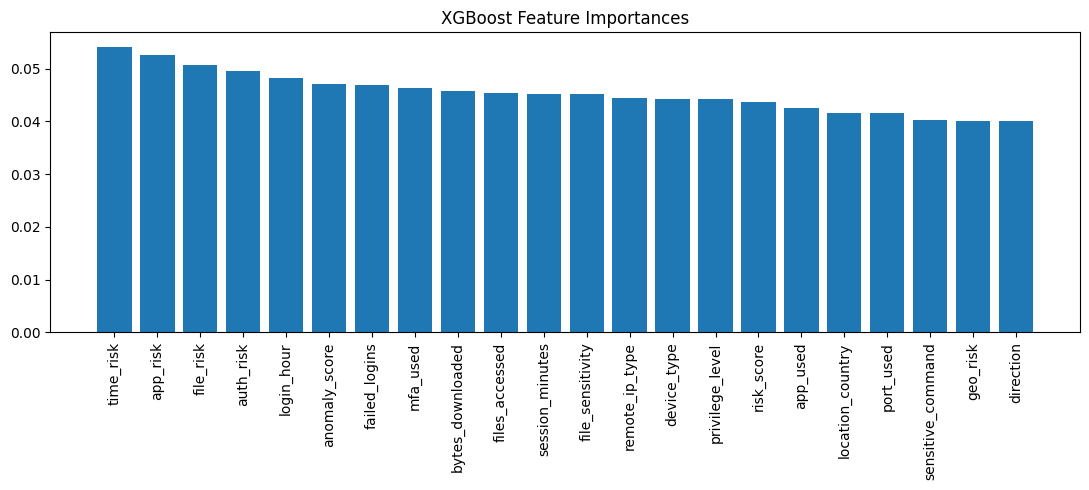

In [37]:
from xgboost import XGBClassifier
# 6. TRAIN/TEST SPLIT (Always stratify!)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 7. XGBoost Model
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# 8. EVALUATION
xgb_preds = xgb.predict(X_test)

print('=== XGBoost Baseline (Test Set) ===')
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_preds, labels=[1, 0]))
print("Classification Report:\n", classification_report(y_test, xgb_preds))

# 9. (Optional) FEATURE IMPORTANCE
import matplotlib.pyplot as plt
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(features)
plt.figure(figsize=(11, 5))
plt.title('XGBoost Feature Importances')
plt.bar(range(len(importances)), importances[indices], tick_label=feature_names[indices])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [13]:
# 1. ENCODE CATEGORICAL FEATURES
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

categorical = [
    'privilege_level', 'device_type', 'location_country', 'remote_ip_type',
    'direction', 'app_used', 'file_sensitivity', 'mfa_used'
]
for col in categorical:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 2. SCALE FEATURES
X = df[features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df['is_anomaly'].astype(int).values


In [15]:
# 5. ENCODE CATEGORICAL FEATURES
categorical = [
    'privilege_level', 'department', 'device_type', 'location_country', 'remote_ip_type',
    'direction', 'app_used', 'file_sensitivity', 'mfa_used'
]
for col in categorical:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 6. SCALE FEATURES TO [0,1]
X = df[features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print(confusion_matrix(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


[[11286     0]
 [  594     0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11286
           1       0.00      0.00      0.00       594

    accuracy                           0.95     11880
   macro avg       0.47      0.50      0.49     11880
weighted avg       0.90      0.95      0.93     11880



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
